# Recommendations with IBM

In this notebook, you will be putting your recommendation skills to use on real data from the IBM Watson Studio platform. 


You may either submit your notebook through the workspace here, or you may work from your local machine and submit through the next page.  Either way assure that your code passes the project [RUBRIC](https://review.udacity.com/#!/rubrics/2322/view).  **Please save regularly.**

By following the table of contents, you will build out a number of different methods for making recommendations that can be used for different situations. 


## Table of Contents

I. [Exploratory Data Analysis](#Exploratory-Data-Analysis)<br>
II. [Rank Based Recommendations](#Rank)<br>
III. [User-User Based Collaborative Filtering](#User-User)<br>
IV. [Matrix Factorization](#Matrix-Fact)<br>
V. [Extras & Concluding](#conclusions)

At the end of the notebook, you will find directions for how to submit your work.  Let's get started by importing the necessary libraries and reading in the data.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import project_tests as t
import pickle

%matplotlib inline

df = pd.read_csv('data/user-item-interactions.csv')
df_content = pd.read_csv('data/articles_community.csv')
del df['Unnamed: 0']
del df_content['Unnamed: 0']

# Show df to get an idea of the data
df.head()

,article_id,title,email
0,1430.0,"using pixiedust for fast, flexible, and easier...",ef5f11f77ba020cd36e1105a00ab868bbdbf7fe7
1,1314.0,healthcare python streaming application demo,083cbdfa93c8444beaa4c5f5e0f5f9198e4f9e0b
2,1429.0,use deep learning for image classification,b96a4f2e92d8572034b1e9b28f9ac673765cd074
3,1338.0,ml optimization using cognitive assistant,06485706b34a5c9bf2a0ecdac41daf7e7654ceb7
4,1276.0,deploy your python model as a restful api,f01220c46fc92c6e6b161b1849de11faacd7ccb2


In [2]:
# Show df_content to get an idea of the data
df_content.head()

,doc_body,doc_description,doc_full_name,doc_status,article_id
0,Skip navigation Sign in SearchLoading...\r\n\r...,Detect bad readings in real time using Python ...,Detect Malfunctioning IoT Sensors with Streami...,Live,0
1,No Free Hunch Navigation * kaggle.com\r\n\r\n ...,"See the forest, see the trees. Here lies the c...",Communicating data science: A guide to present...,Live,1
2,☰ * Login\r\n * Sign Up\r\n\r\n * Learning Pat...,Here’s this week’s news in Data Science and Bi...,"This Week in Data Science (April 18, 2017)",Live,2
3,"DATALAYER: HIGH THROUGHPUT, LOW LATENCY AT SCA...",Learn how distributed DBs solve the problem of...,DataLayer Conference: Boost the performance of...,Live,3
4,Skip navigation Sign in SearchLoading...\r\n\r...,This video demonstrates the power of IBM DataS...,Analyze NY Restaurant data using Spark in DSX,Live,4


### <a class="anchor" id="Exploratory-Data-Analysis">Part I : Exploratory Data Analysis</a>

Use the dictionary and cells below to provide some insight into the descriptive statistics of the data.

`1.` What is the distribution of how many articles a user interacts with in the dataset?  Provide a visual and descriptive statistics to assist with giving a look at the number of times each user interacts with an article.  

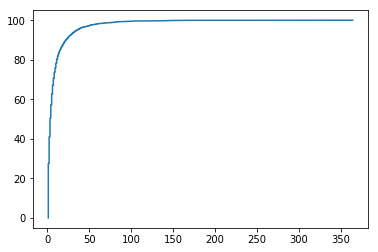

In [3]:
interation_series = np.sort(pd.Series(df[df.email.notna()].groupby('email').size()).values)
user_count = np.cumsum(np.ones(len(interation_series)))*100/len(interation_series)
plt.plot(interation_series, user_count)

In [4]:
interaction_count = len(interation_series)

In [5]:
# Fill in the median and maximum number of user_article interactios below

median_val = (interation_series[int((interaction_count-1)/2)] + interation_series[int(interaction_count/2)])/2
# 50% of individuals interact with ____ number of articles or fewer.
max_views_by_user = interation_series[-1]
# The maximum number of user-article interactions by any 1 user is ______.
print("50% of individuals interact with {} number of articles or fewer.".format(median_val))
print("The maximum number of user-article interactions by any 1 user is {}".format(max_views_by_user))

50% of individuals interact with 3.0 number of articles or fewer.
The maximum number of user-article interactions by any 1 user is 364


`2.` Explore and remove duplicate articles from the **df_content** dataframe.  

In [6]:
# Find and explore duplicate articles
df_content.shape[0], len(df_content.article_id.value_counts())

(1056, 1051)

In [7]:
# Remove any rows that have the same article_id - only keep the first
df_content = df_content.drop_duplicates(['article_id'], keep='first')
df_content.shape[0]

1051

`3.` Use the cells below to find:

**a.** The number of unique articles that have an interaction with a user.  
**b.** The number of unique articles in the dataset (whether they have any interactions or not).<br>
**c.** The number of unique users in the dataset. (excluding null values) <br>
**d.** The number of user-article interactions in the dataset.

In [8]:
df_content.article_id.isna().sum()

0

In [9]:
unique_articles = len(df.article_id.unique())# The number of unique articles that have at least one interaction
total_articles = df_content.shape[0]# The number of unique articles on the IBM platform
unique_users = len(df[df.email.notna()]['email'].unique())# The number of unique users
user_article_interactions = df.shape[0]# The number of user-article interactions

In [10]:
print("The number of unique articles that have at least one interaction - {}".format(unique_articles))
print("The number of unique articles on the IBM platform - {}".format(total_articles))
print("The number of unique users - {}".format(unique_users))
print("The number of user-article interactions - {}".format(user_article_interactions))

The number of unique articles that have at least one interaction - 714
The number of unique articles on the IBM platform - 1051
The number of unique users - 5148
The number of user-article interactions - 45993


`4.` Use the cells below to find the most viewed **article_id**, as well as how often it was viewed.  After talking to the company leaders, the `email_mapper` function was deemed a reasonable way to map users to ids.  There were a small number of null values, and it was found that all of these null values likely belonged to a single user (which is how they are stored using the function below).

In [11]:
df.groupby('article_id').size().sort_values(ascending=False).iloc[:1]

article_id
1429.0    937
dtype: int64

In [12]:
most_viewed_article_id = '1429.0'# The most viewed article in the dataset as a string with one value following the decimal 
max_views = 937# The most viewed article in the dataset was viewed how many times?

In [13]:
## No need to change the code here - this will be helpful for later parts of the notebook
# Run this cell to map the user email to a user_id column and remove the email column

def email_mapper():
    coded_dict = dict()
    cter = 1
    email_encoded = []
    
    for val in df['email']:
        if val not in coded_dict:
            coded_dict[val] = cter
            cter+=1
        
        email_encoded.append(coded_dict[val])
    return email_encoded

email_encoded = email_mapper()
del df['email']
df['user_id'] = email_encoded

# show header
df.head()

,article_id,title,user_id
0,1430.0,"using pixiedust for fast, flexible, and easier...",1
1,1314.0,healthcare python streaming application demo,2
2,1429.0,use deep learning for image classification,3
3,1338.0,ml optimization using cognitive assistant,4
4,1276.0,deploy your python model as a restful api,5


In [14]:
len(df.user_id.unique())

5149

In [15]:
## If you stored all your results in the variable names above, 
## you shouldn't need to change anything in this cell

sol_1_dict = {
    '`50% of individuals have _____ or fewer interactions.`': median_val,
    '`The total number of user-article interactions in the dataset is ______.`': user_article_interactions,
    '`The maximum number of user-article interactions by any 1 user is ______.`': max_views_by_user,
    '`The most viewed article in the dataset was viewed _____ times.`': max_views,
    '`The article_id of the most viewed article is ______.`': most_viewed_article_id,
    '`The number of unique articles that have at least 1 rating ______.`': unique_articles,
    '`The number of unique users in the dataset is ______`': unique_users,
    '`The number of unique articles on the IBM platform`': total_articles
}

# Test your dictionary against the solution
t.sol_1_test(sol_1_dict)

It looks like you have everything right here! Nice job!


### <a class="anchor" id="Rank">Part II: Rank-Based Recommendations</a>

Unlike in the earlier lessons, we don't actually have ratings for whether a user liked an article or not.  We only know that a user has interacted with an article.  In these cases, the popularity of an article can really only be based on how often an article was interacted with.

`1.` Fill in the function below to return the **n** top articles ordered with most interactions as the top. Test your function using the tests below.

In [16]:
def get_top_article_ids(n, df=df):
    '''
    INPUT:
    n - (int) the number of top articles to return
    df - (pandas dataframe) df as defined at the top of the notebook 
    
    OUTPUT:
    top_articles - (list) A list of the top 'n' article titles 
    
    '''
    # Your code here
    top_articles = df.groupby('article_id').size().sort_values(ascending=False).index[:n]
    top_articles = ['{:.1f}'.format(x) for x in top_articles]
    return top_articles # Return the top article ids

def get_top_articles(n, df=df):
    '''
    INPUT:
    n - (int) the number of top articles to return
    df - (pandas dataframe) df as defined at the top of the notebook 
    
    OUTPUT:
    top_articles - (list) A list of the top 'n' article titles 
    
    '''
    # Your code here
    top_ids = get_top_article_ids(n, df)
    sub_df = df.groupby('article_id').first()
    top_articles = list(sub_df[sub_df.index.isin(top_ids)]['title'])
    return top_articles # Return the top article titles from df (not df_content)

In [17]:
print(get_top_articles(10))
print(get_top_article_ids(10))

['analyze energy consumption in buildings', 'apache spark lab, part 1: basic concepts', 'finding optimal locations of new store using decision optimization', 'gosales transactions for logistic regression model', 'healthcare python streaming application demo', 'insights from new york car accident reports', 'predicting churn with the spss random tree algorithm', 'use xgboost, scikit-learn & ibm watson machine learning apis', 'use deep learning for image classification', 'visualize car data with brunel']
['1429.0', '1330.0', '1431.0', '1427.0', '1364.0', '1314.0', '1293.0', '1170.0', '1162.0', '1304.0']


In [18]:
# Test your function by returning the top 5, 10, and 20 articles
top_5 = get_top_articles(5)
top_10 = get_top_articles(10)
top_20 = get_top_articles(20)

# Test each of your three lists from above
t.sol_2_test(get_top_articles)

Your top_5 looks like the solution list! Nice job.
Your top_10 looks like the solution list! Nice job.
Your top_20 looks like the solution list! Nice job.


### <a class="anchor" id="User-User">Part III: User-User Based Collaborative Filtering</a>


`1.` Use the function below to reformat the **df** dataframe to be shaped with users as the rows and articles as the columns.  

* Each **user** should only appear in each **row** once.


* Each **article** should only show up in one **column**.  


* **If a user has interacted with an article, then place a 1 where the user-row meets for that article-column**.  It does not matter how many times a user has interacted with the article, all entries where a user has interacted with an article should be a 1.  


* **If a user has not interacted with an item, then place a zero where the user-row meets for that article-column**. 

Use the tests to make sure the basic structure of your matrix matches what is expected by the solution.

In [19]:
# create the user-article matrix with 1's and 0's

def create_user_item_matrix(df):
    '''
    INPUT:
    df - pandas dataframe with article_id, title, user_id columns
    
    OUTPUT:
    user_item - user item matrix 
    
    Description:
    Return a matrix with user ids as rows and article ids on the columns with 1 values where a user interacted with 
    an article and a 0 otherwise
    '''
    # Fill in the function here
    sub_df = df[['user_id', 'article_id']]
    sub_df['count'] = pd.Series(np.ones(len(sub_df)))
    user_item = sub_df.groupby(['user_id', 'article_id'])['count'].first().unstack()
    user_item.fillna(0, inplace=True)
    return user_item # return the user_item matrix 

user_item = create_user_item_matrix(df)

In [20]:
## Tests: You should just need to run this cell.  Don't change the code.
assert user_item.shape[0] == 5149, "Oops!  The number of users in the user-article matrix doesn't look right."
assert user_item.shape[1] == 714, "Oops!  The number of articles in the user-article matrix doesn't look right."
assert user_item.sum(axis=1)[1] == 36, "Oops!  The number of articles seen by user 1 doesn't look right."
print("You have passed our quick tests!  Please proceed!")

You have passed our quick tests!  Please proceed!


`2.` Complete the function below which should take a user_id and provide an ordered list of the most similar users to that user (from most similar to least similar).  The returned result should not contain the provided user_id, as we know that each user is similar to him/herself. Because the results for each user here are binary, it (perhaps) makes sense to compute similarity as the dot product of two users. 

Use the tests to test your function.

In [21]:
def find_similar_users(user_id, user_item=user_item):
    '''
    INPUT:
    user_id - (int) a user_id
    user_item - (pandas dataframe) matrix of users by articles: 
                1's when a user has interacted with an article, 0 otherwise
    
    OUTPUT:
    similar_users - (list) an ordered list where the closest users (largest dot product users)
                    are listed first
    
    Description:
    Computes the similarity of every pair of users based on the dot product
    Returns an ordered
    
    '''
    user_interaction_arr = np.array(user_item.loc[user_id, :])
    sim_scores = []
    # compute similarity of each user to the provided user
    for u_id in list(user_item.index):
        u_interaction_arr = user_item.loc[u_id, :]
        sim_scores.append(np.dot(user_interaction_arr, np.array(u_interaction_arr)))
    
    sub_df = pd.DataFrame(columns=['u_id', 'similarity'])
    sub_df['u_id'] = pd.Series(user_item.index)
    sub_df['similarity'] = pd.Series(sim_scores)
    # sort by similarity
    sub_df = sub_df.sort_values(by='similarity', ascending=False) 
    # create list of just the ids
    most_similar_users = np.array(sub_df['u_id'])
    # remove the own user's id
    index = np.where(most_similar_users == user_id)
    most_similar_users = np.delete(most_similar_users, index)
    return most_similar_users # return a list of the users in order from most to least similar
        

In [22]:
# Do a spot check of your function
print("The 10 most similar users to user 1 are: {}".format(find_similar_users(1)[:10]))
print("The 5 most similar users to user 3933 are: {}".format(find_similar_users(3933)[:5]))
print("The 3 most similar users to user 46 are: {}".format(find_similar_users(46)[:3]))

The 10 most similar users to user 1 are: [3933   23 3782  203 4459 3870  131 4201   46 5041]
The 5 most similar users to user 3933 are: [   1   23 3782  203 4459]
The 3 most similar users to user 46 are: [4201 3782   23]


`3.` Now that you have a function that provides the most similar users to each user, you will want to use these users to find articles you can recommend.  Complete the functions below to return the articles you would recommend to each user. 

In [23]:
def get_article_names(article_ids, df=df):
    '''
    INPUT:
    article_ids - (list) a list of article ids
    df - (pandas dataframe) df as defined at the top of the notebook
    
    OUTPUT:
    article_names - (list) a list of article names associated with the list of article ids 
                    (this is identified by the title column)
    '''
    # Your code here
    sub_df = df.groupby('article_id').first()
    article_names = list(sub_df[sub_df.index.isin(article_ids)]['title'])
    return article_names # Return the article names associated with list of article ids


def get_user_articles(user_id, user_item=user_item):
    '''
    INPUT:
    user_id - (int) a user id
    user_item - (pandas dataframe) matrix of users by articles: 
                1's when a user has interacted with an article, 0 otherwise
    
    OUTPUT:
    article_ids - (list) a list of the article ids seen by the user
    article_names - (list) a list of article names associated with the list of article ids 
                    (this is identified by the title column in df)
    
    Description:
    Provides a list of the article_ids and article titles that have been seen by a user
    '''
    # Your code here
    ids = np.array(user_item.columns)
    user_row = np.array(user_item.loc[user_id, :])
    seen_index = np.where(user_row == 1)
    article_ids = list(ids[seen_index])
    article_names = list(df[df['article_id'].isin(article_ids)]['title'])
    article_ids = ['{:.1f}'.format(x) for x in article_ids]
    return article_ids, article_names # return the ids and names


def user_user_recs(user_id, m=10):
    '''
    INPUT:
    user_id - (int) a user id
    m - (int) the number of recommendations you want for the user
    
    OUTPUT:
    recs - (list) a list of recommendations for the user
    
    Description:
    Loops through the users based on closeness to the input user_id
    For each user - finds articles the user hasn't seen before and provides them as recs
    Does this until m recommendations are found
    
    Notes:
    Users who are the same closeness are chosen arbitrarily as the 'next' user
    
    For the user where the number of recommended articles starts below m 
    and ends exceeding m, the last items are chosen arbitrarily
    
    '''
    # Your code here
    similar_users = find_similar_users(user_id)
    recs = []
    seen_articles, _ = get_user_articles(user_id)
    for u_id in similar_users:
        prob_articles, _ = get_user_articles(u_id)
        prob_articles = np.setdiff1d(np.array(prob_articles), np.array(seen_articles))
        prob_articles = np.setdiff1d(np.array(prob_articles), np.array(recs))
        recs = recs + list(prob_articles)
        if len(recs) >= m:
            break
    return recs[:m] # return your recommendations for this user_id    

In [24]:
# Check Results
get_article_names(user_user_recs(1, 10)) # Return 10 recommendations for user 1

['520    using notebooks with pixiedust for fast, flexi...\nName: title, dtype: object',
 'recommender systems: approaches & algorithms',
 '1448    i ranked every intro to data science course on...\nName: title, dtype: object',
 'data tidying in data science experience',
 'a tensorflow regression model to predict house values',
 'airbnb data for analytics: mallorca reviews',
 'airbnb data for analytics: vancouver listings',
 'analyze facebook data using ibm watson and watson studio',
 'analyze accident reports on amazon emr spark',
 'analyze energy consumption in buildings']

In [25]:
# Test your functions here - No need to change this code - just run this cell
assert set(get_article_names(['1024.0', '1176.0', '1305.0', '1314.0', '1422.0', '1427.0'])) == set(['using deep learning to reconstruct high-resolution audio', 'build a python app on the streaming analytics service', 'gosales transactions for naive bayes model', 'healthcare python streaming application demo', 'use r dataframes & ibm watson natural language understanding', 'use xgboost, scikit-learn & ibm watson machine learning apis']), "Oops! Your the get_article_names function doesn't work quite how we expect."
assert set(get_article_names(['1320.0', '232.0', '844.0'])) == set(['housing (2015): united states demographic measures','self-service data preparation with ibm data refinery','use the cloudant-spark connector in python notebook']), "Oops! Your the get_article_names function doesn't work quite how we expect."
assert set(get_user_articles(20)[0]) == set(['1320.0', '232.0', '844.0'])
assert set(get_user_articles(20)[1]) == set(['housing (2015): united states demographic measures', 'self-service data preparation with ibm data refinery','use the cloudant-spark connector in python notebook'])
assert set(get_user_articles(2)[0]) == set(['1024.0', '1176.0', '1305.0', '1314.0', '1422.0', '1427.0'])
assert set(get_user_articles(2)[1]) == set(['using deep learning to reconstruct high-resolution audio', 'build a python app on the streaming analytics service', 'gosales transactions for naive bayes model', 'healthcare python streaming application demo', 'use r dataframes & ibm watson natural language understanding', 'use xgboost, scikit-learn & ibm watson machine learning apis'])
print("If this is all you see, you passed all of our tests!  Nice job!")

If this is all you see, you passed all of our tests!  Nice job!


`4.` Now we are going to improve the consistency of the **user_user_recs** function from above.  

* Instead of arbitrarily choosing when we obtain users who are all the same closeness to a given user - choose the users that have the most total article interactions before choosing those with fewer article interactions.


* Instead of arbitrarily choosing articles from the user where the number of recommended articles starts below m and ends exceeding m, choose articles with the articles with the most total interactions before choosing those with fewer total interactions. This ranking should be  what would be obtained from the **top_articles** function you wrote earlier.

In [26]:
def get_top_sorted_users(user_id, df=df, user_item=user_item):
    '''
    INPUT:
    user_id - (int)
    df - (pandas dataframe) df as defined at the top of the notebook 
    user_item - (pandas dataframe) matrix of users by articles: 
            1's when a user has interacted with an article, 0 otherwise
    
            
    OUTPUT:
    neighbors_df - (pandas dataframe) a dataframe with:
                    neighbor_id - is a neighbor user_id
                    similarity - measure of the similarity of each user to the provided user_id
                    num_interactions - the number of articles viewed by the user - if a u
                    
    Other Details - sort the neighbors_df by the similarity and then by number of interactions where 
                    highest of each is higher in the dataframe
     
    '''
    # Your code here
    user_interaction_arr = np.array(user_item.loc[user_id, :])
    sim_scores, user_articles_read = [], []
    # compute similarity of each user to the provided user
    for u_id in list(user_item.index):
        u_interaction_arr = user_item.loc[u_id, :]
        sim_scores.append(np.dot(user_interaction_arr, np.array(u_interaction_arr)))
        user_articles_read.append(np.sum(np.array(u_interaction_arr)))
    
    sub_df = pd.DataFrame(columns=['u_id', 'similarity', 'articles_read'])
    sub_df['u_id'] = pd.Series(user_item.index)
    sub_df['similarity'] = pd.Series(sim_scores)
    sub_df['articles_read'] = pd.Series(user_articles_read)
    # sort by similarity and then count of articles read by the user 
    sub_df = sub_df.sort_values(by=['similarity', 'articles_read'], ascending=False) 
    # create list of just the ids
    neighbors_df = np.array(sub_df['u_id'])
    # remove the own user's id
    index = np.where(neighbors_df == user_id)
    neighbors_df = list(np.delete(neighbors_df, index))
    return neighbors_df # Return the dataframe specified in the doc_string

In [27]:
get_top_sorted_users(1)[:10]

[3933, 23, 3782, 203, 4459, 131, 3870, 46, 4201, 49]

In [28]:
def sort_articles_by_interactions_desc(article_ids, df=df):
    '''
    INPUT:
    article_ids - list of article ids which needs to be ordered by popularity among readers
    df - (pandas dataframe) df as defined at the top of the notebook 
    
    OUTPUT:
    inter_count - list of article ids sorted according to popularity 
    '''
    sub_df = df.groupby('article_id').count()
    sub_df = sub_df[sub_df.index.isin(article_ids)]
    sub_df.sort_values(by='title')
    return list(sub_df.index)

In [29]:
def user_user_recs_part2(user_id, m=10):
    '''
    INPUT:
    user_id - (int) a user id
    m - (int) the number of recommendations you want for the user
    
    OUTPUT:
    recs - (list) a list of recommendations for the user by article id
    rec_names - (list) a list of recommendations for the user by article title
    
    Description:
    Loops through the users based on closeness to the input user_id
    For each user - finds articles the user hasn't seen before and provides them as recs
    Does this until m recommendations are found
    
    Notes:
    * Choose the users that have the most total article interactions 
    before choosing those with fewer article interactions.

    * Choose articles with the articles with the most total interactions 
    before choosing those with fewer total interactions. 
   
    '''
    # Your code here
    similar_users = get_top_sorted_users(user_id)
    recs = []
    seen_articles, _ = get_user_articles(user_id)
    for u_id in similar_users:
        prob_articles, _ = get_user_articles(u_id)
        prob_articles = np.setdiff1d(np.array(prob_articles), np.array(seen_articles))
        prob_articles = np.setdiff1d(np.array(prob_articles), np.array(recs))
        if len(recs) + len(prob_articles) < m:
            recs = recs + list(prob_articles)
            continue
        prob_articles = sort_articles_by_interactions_desc(prob_articles)
        recs = recs + list(prob_articles)
        break
    recs = recs[:m]
    rec_names = get_article_names(recs)
    return recs, rec_names

In [30]:
# Quick spot check - don't change this code - just use it to test your functions
rec_ids, rec_names = user_user_recs_part2(20, 10)
print("The top 10 recommendations for user 20 are the following article ids:")
print(rec_ids)
print()
print("The top 10 recommendations for user 20 are the following article names:")
print(rec_names)

The top 10 recommendations for user 20 are the following article ids:
[12.0, 14.0, 29.0, 33.0, 43.0, 51.0, 109.0, 111.0, 130.0, 142.0]

The top 10 recommendations for user 20 are the following article names:
['timeseries data analysis of iot events by using jupyter notebook', 'got zip code data? prep it for analytics. – ibm watson data lab – medium', 'experience iot with coursera', 'using brunel in ipython/jupyter notebooks', 'deep learning with tensorflow course by big data university', 'modern machine learning algorithms', 'tensorflow quick tips', 'tidy up your jupyter notebooks with scripts', "feature importance and why it's important", 'neural networks for beginners: popular types and applications']


`5.` Use your functions from above to correctly fill in the solutions to the dictionary below.  Then test your dictionary against the solution.  Provide the code you need to answer each following the comments below.

In [31]:
### Tests with a dictionary of results

user1_most_sim = get_top_sorted_users(1)[0]# Find the user that is most similar to user 1 
## The tests are actually looking for the 11st similar user and not the 10th. 3910 is the 10th most similar user
user131_10th_sim = get_top_sorted_users(131)[10]# Find the 10th most similar user to user 131

In [32]:
user1_most_sim, user131_10th_sim, get_top_sorted_users(131)[9]

(3933, 242, 3910)

In [33]:
## Dictionary Test Here
sol_5_dict = {
    'The user that is most similar to user 1.': user1_most_sim, 
    'The user that is the 10th most similar to user 131': user131_10th_sim,
}

t.sol_5_test(sol_5_dict)

This all looks good!  Nice job!


`6.` If we were given a new user, which of the above functions would you be able to use to make recommendations?  Explain.  Can you think of a better way we might make recommendations?  Use the cell below to explain a better method for new users.

**Since there will be no interaction data for new users, it is not possbile to retrieve most similar users. This is what is called a cold start problem. In such cases, we could go by recommending popular articles. Once we have sufficient interaction data for the user, we would then be able to apply the above methods to make recommendations. So whenever a new user comes in, we just recommend the most popular articles.**

`7.` Using your existing functions, provide the top 10 recommended articles you would provide for the a new user below.  You can test your function against our thoughts to make sure we are all on the same page with how we might make a recommendation.

In [34]:
new_user = '0.0'

# What would your recommendations be for this new user '0.0'?  As a new user, they have no observed articles.
# Provide a list of the top 10 article ids you would give to 
new_user_recs = get_top_article_ids(10)# Your recommendations here

In [35]:
assert set(new_user_recs) == set(['1314.0','1429.0','1293.0','1427.0','1162.0','1364.0','1304.0','1170.0','1431.0','1330.0']), "Oops!  It makes sense that in this case we would want to recommend the most popular articles, because we don't know anything about these users."

print("That's right!  Nice job!")

That's right!  Nice job!


### <a class="anchor" id="Matrix-Fact">Part IV: Matrix Factorization</a>

In this part of the notebook, you will build use matrix factorization to make article recommendations to the users on the IBM Watson Studio platform.

`1.` You should have already created a **user_item** matrix above in **question 1** of **Part III** above.  This first question here will just require that you run the cells to get things set up for the rest of **Part V** of the notebook. 

In [36]:
# Load the matrix here
user_item_matrix = pd.read_pickle('user_item_matrix.p')

In [37]:
# quick look at the matrix
user_item_matrix.head()

article_id,0.0,100.0,1000.0,1004.0,1006.0,1008.0,101.0,1014.0,1015.0,1016.0,...,977.0,98.0,981.0,984.0,985.0,986.0,990.0,993.0,996.0,997.0
user_id,,,,,,,,,,,,,,,,,,,,,
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


`2.` In this situation, you can use Singular Value Decomposition from [numpy](https://docs.scipy.org/doc/numpy-1.14.0/reference/generated/numpy.linalg.svd.html) on the user-item matrix.  Use the cell to perform SVD, and explain why this is different than in the lesson.

In [38]:
# Perform SVD on the User-Item Matrix Here

u, s, vt = np.linalg.svd(user_item_matrix)# use the built in to get the three matrices

**SVD cannot be used when the matrix has null values. But in this case since we have replaced all the nans' with zeros, we can use the conventional SVD matrix factorisation process**

`3.` Now for the tricky part, how do we choose the number of latent features to use?  Running the below cell, you can see that as the number of latent features increases, we obtain a lower error rate on making predictions for the 1 and 0 values in the user-item matrix.  Run the cell below to get an idea of how the accuracy improves as we increase the number of latent features.

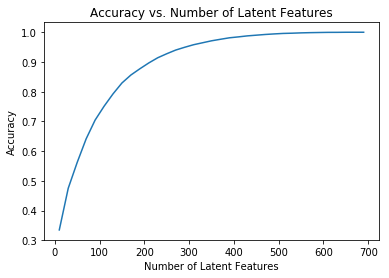

In [39]:
num_latent_feats = np.arange(10,700+10,20)
sum_errs = []

for k in num_latent_feats:
    # restructure with k latent features
    s_new, u_new, vt_new = np.diag(s[:k]), u[:, :k], vt[:k, :]
    
    # take dot product
    user_item_est = np.around(np.dot(np.dot(u_new, s_new), vt_new))
    
    # compute error for each prediction to actual value
    diffs = np.subtract(user_item_matrix, user_item_est)
    
    # total errors and keep track of them
    err = np.sum(np.sum(np.abs(diffs)))
    sum_errs.append(err)
    
    
plt.plot(num_latent_feats, 1 - np.array(sum_errs)/df.shape[0]);
plt.xlabel('Number of Latent Features');
plt.ylabel('Accuracy');
plt.title('Accuracy vs. Number of Latent Features');

`4.` From the above, we can't really be sure how many features to use, because simply having a better way to predict the 1's and 0's of the matrix doesn't exactly give us an indication of if we are able to make good recommendations.  Instead, we might split our dataset into a training and test set of data, as shown in the cell below.  

Use the code from question 3 to understand the impact on accuracy of the training and test sets of data with different numbers of latent features. Using the split below: 

* How many users can we make predictions for in the test set?  
* How many users are we not able to make predictions for because of the cold start problem?
* How many articles can we make predictions for in the test set?  
* How many articles are we not able to make predictions for because of the cold start problem?

In [40]:
df.head()

,article_id,title,user_id
0,1430.0,"using pixiedust for fast, flexible, and easier...",1
1,1314.0,healthcare python streaming application demo,2
2,1429.0,use deep learning for image classification,3
3,1338.0,ml optimization using cognitive assistant,4
4,1276.0,deploy your python model as a restful api,5


In [51]:
df_train = df.head(40000)
df_test = df.tail(5993)

def create_user_item_mat(df):
    df['title'] = df['title'].apply(lambda x: 1)
    df = df.groupby(['user_id', 'article_id'])['title'].first().unstack()
    df = df.fillna(0)
    return df

def create_test_and_train_user_item(df_train, df_test):
    '''
    INPUT:
    df_train - training dataframe
    df_test - test dataframe
    
    OUTPUT:
    user_item_train - a user-item matrix of the training dataframe 
                      (unique users for each row and unique articles for each column)
    user_item_test - a user-item matrix of the testing dataframe 
                    (unique users for each row and unique articles for each column)
    test_idx - all of the test user ids
    test_arts - all of the test article ids
    
    '''
    # Your code here
    user_item_train, user_item_test = create_user_item_mat(df_train), create_user_item_mat(df_test)
    test_idx = np.array(df_test['user_id'].unique())
    test_arts = np.array(df_test['article_id'].unique())
    return user_item_train, user_item_test, test_idx, test_arts

user_item_train, user_item_test, test_idx, test_arts = create_test_and_train_user_item(df_train, df_test)

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """


In [52]:
print("seen users in test set - {}".format(len(np.intersect1d(np.array(user_item_train.index), test_idx))))
print("new users in test set - {}".format(len(np.setdiff1d(test_idx, np.array(user_item_train.index)))))
print("seen articles in test set - {}".format(len(np.intersect1d(np.array(user_item_train.columns), test_arts))))
print("new articles in test set - {}".format(len(np.setdiff1d(test_arts, np.array(user_item_train.columns)))))

seen users in test set - 20
new users in test set - 662
seen articles in test set - 574
new articles in test set - 0


In [53]:
# Replace the values in the dictionary below
a = 662 
b = 574 
c = 20 
d = 0 


sol_4_dict = {
    'How many users can we make predictions for in the test set?': c,
    'How many users in the test set are we not able to make predictions for because of the cold start problem?': a,
    'How many movies can we make predictions for in the test set?': b,
    'How many movies in the test set are we not able to make predictions for because of the cold start problem?': d
}

t.sol_4_test(sol_4_dict)

Awesome job!  That's right!  All of the test movies are in the training data, but there are only 20 test users that were also in the training set.  All of the other users that are in the test set we have no data on.  Therefore, we cannot make predictions for these users using SVD.


`5.` Now use the **user_item_train** dataset from above to find U, S, and V transpose using SVD. Then find the subset of rows in the **user_item_test** dataset that you can predict using this matrix decomposition with different numbers of latent features to see how many features makes sense to keep based on the accuracy on the test data. This will require combining what was done in questions `2` - `4`.

Use the cells below to explore how well SVD works towards making predictions for recommendations on the test data.  

In [87]:
seen_users = np.intersect1d(np.array(user_item_train.index), test_idx)
seen_users_ind = list(np.where(user_item_train.index.isin(seen_users))[0])

In [61]:
# fit SVD on the user_item_train matrix
u_train, s_train, vt_train = np.linalg.svd(user_item_train)# fit svd similar to above then use the cells below
u_train.shape, s_train.shape, vt_train.shape

((4487, 4487), (714,), (714, 714))

In [97]:
seen_users_ind_test = list(np.where(user_item_test.index.isin(seen_users))[0])
test_articles_idx = list(np.where(user_item_test.columns.isin(test_arts))[0])

In [117]:
sum_ = 0;
for i in range(300):
    sum_ += s_train[i]**2
sum_/np.sum(s_train**2)

0.92077617721600513

**We see that the first 300 latent features contribute to 92% variance**

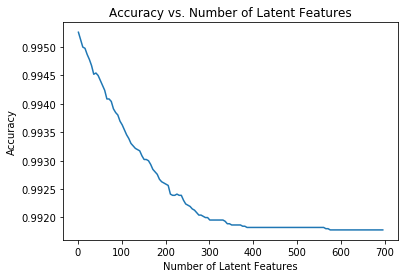

In [119]:
# Use these cells to see how well you can use the training 
# decomposition to predict on test data
num_latent_feats = np.arange(1,701,5)
sum_errs = []

for k in num_latent_feats:
    # restructure with k latent features
    s_new, u_new, vt_new = np.diag(s_train[:k]), u_train[list(seen_users_ind), :k], vt_train[:k, test_articles_idx]
    
    # take dot product
    user_item_pred = np.around(np.dot(np.dot(u_new, s_new), vt_new))
    
    # compute error for each prediction to actual value
    diffs = np.subtract(np.array(user_item_test.iloc[seen_users_ind_test, :]), user_item_pred)
    
    # total errors and keep track of them
    err = np.sum(np.sum(np.abs(diffs)))
    sum_errs.append(err)
    
    
plt.plot(num_latent_feats, 1 - np.array(sum_errs)/df.shape[0]);
plt.xlabel('Number of Latent Features');
plt.ylabel('Accuracy');
plt.title('Accuracy vs. Number of Latent Features');

`6.` Use the cell below to comment on the results you found in the previous question. Given the circumstances of your results, discuss what you might do to determine if the recommendations you make with any of the above recommendation systems are an improvement to how users currently find articles? 

**Since the test data set we can predict for is very small, we cannot really check the performance of our recommendation system. To improve the concentioanl SVD model, we could take in few samples of the unseen users into the train dataset, so that we can make more predictions. Then we can do a proper testing of our model. For now, we can test our model only using these 20 users, which might not a be proper generalisation.**

*Recommendations for New Users - Knowledge based filtering plus Collaborative filtering*
**For new users, we can always go with popular suggestions and then take in their reviews. We could then construct a user item interaction array for that user, taking into account only liked articles. Then we can go ahead with finding out most similar neighbors and making recommendations from the set of reads of these neighbors, which are not already read by the user**

*Recommendations for existing users - Collaborative Filtering*
**For existing users, we could simply do a content based filtering where we find the most similar neighbors and picks recommendations from their reads which are not already read by the user.**

*Testing the performance of the model*
**Whenever a recommendation is being tried by the user, we need to have a feedback mechanism where the user reviews the recommnendation after the read. This way we'll be able to score our recommendation model. One more approach would be to do something similar to AB testing, where we provide recommendations to a random half of the users. Then we monitor how frequently users of both control group and experimental group come back to pick another article.**

<a id='conclusions'></a>
### Extras
Using your workbook, you could now save your recommendations for each user, develop a class to make new predictions and update your results, and make a flask app to deploy your results.  These tasks are beyond what is required for this project.  However, from what you learned in the lessons, you certainly capable of taking these tasks on to improve upon your work here!


## Conclusion

> Congratulations!  You have reached the end of the Recommendations with IBM project! 

> **Tip**: Once you are satisfied with your work here, check over your report to make sure that it is satisfies all the areas of the [rubric](https://review.udacity.com/#!/rubrics/2322/view). You should also probably remove all of the "Tips" like this one so that the presentation is as polished as possible.


## Directions to Submit

> Before you submit your project, you need to create a .html or .pdf version of this notebook in the workspace here. To do that, run the code cell below. If it worked correctly, you should get a return code of 0, and you should see the generated .html file in the workspace directory (click on the orange Jupyter icon in the upper left).

> Alternatively, you can download this report as .html via the **File** > **Download as** submenu, and then manually upload it into the workspace directory by clicking on the orange Jupyter icon in the upper left, then using the Upload button.

> Once you've done this, you can submit your project by clicking on the "Submit Project" button in the lower right here. This will create and submit a zip file with this .ipynb doc and the .html or .pdf version you created. Congratulations! 

In [ ]:
from subprocess import call
call(['python', '-m', 'nbconvert', 'Recommendations_with_IBM.ipynb'])